In [1]:
pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import lightgbm as lgb
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import os

warnings.filterwarnings('ignore')

In [4]:
# 1. Load data
df = pd.read_csv('Traffic.csv')

In [5]:
# 2. Feature engineering: Binary target for 'Traffic Situation'
df['Target'] = df['Traffic Situation'].apply(lambda x: 1 if x in ['heavy', 'high'] else 0)

In [6]:
# 3. Handle missing values
def fill_missing(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    return df

df = fill_missing(df)

In [7]:
# 4. One-hot encode categorical features (except target)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Traffic Situation']]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [8]:
# 5. Drop non-numeric columns before modeling
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
df = df.drop(non_numeric_cols, axis=1)

In [9]:
# 5b. Feature selection - remove highly correlated features
corr_matrix = df.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.95)]
df = df.drop(to_drop, axis=1)
print(f"Features after correlation removal: {df.shape[1]}")
print(f"Removed features: {to_drop}")

Features after correlation removal: 107
Removed features: ['CarCount']


After checking for high correlation between features, 1 column (CarCount) was identified as redundant and removed. The total number of features in the dataset is now 107.

This step improves model performance and generalization by eliminating features that carry similar information. The printed output confirms what was removed and how many features remain.

In [10]:
# 6. Feature/target split
X = df.drop('Target', axis=1)
y = df['Target']

In [11]:
# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# 7b. Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Resampled training set target distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Original training set shape: (2380, 106)
Resampled training set shape: (3156, 106)
Resampled training set target distribution:
Target
0    0.5
1    0.5
Name: proportion, dtype: float64


The output shows that:

* Originally, the training set had 2,380 samples with 106 features.
* After applying SMOTE, the training set increased to 3,156 samples, indicating that synthetic samples were added for the minority class.
* The final class distribution is perfectly balanced: 50% for class 0 (not heavy traffic) and 50% for class 1 (heavy/high traffic).

This confirms that SMOTE successfully addressed the class imbalance, which can improve model performance, especially for minority class prediction.

In [13]:
# 8. Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [14]:
# 9. Baseline LightGBM

# Suppress all warnings from sklearn, lightgbm, etc.
warnings.filterwarnings("ignore")

# Set LightGBM log level to suppress internal training messages
os.environ["LIGHTGBM_VERBOSE"] = "0"

# Clean column names: replace spaces and symbols with underscores
df.columns = df.columns.str.replace(r'[^A-Za-z0-9]+', '_', regex=True)

# Drop unnecessary column if exists
if 'Total' in df.columns:
    df = df.drop(columns=["Total"])

# Encode categorical features (example: Time, Day_of_the_week, Traffic_Situation)
label_enc = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = label_enc.fit_transform(df[col])

# Define target and features
target_col = "Target"
X = df.drop(columns=[target_col])
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resample using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter grid (for initial fit to get baseline performance)
param_grid = {
    'n_estimators': [100], # Use a smaller grid for baseline
    'max_depth': [6],
    'learning_rate': [0.1],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

# LightGBM classifier
lgb_clf = lgb.LGBMClassifier(random_state=42, verbose=-1)

# GridSearchCV with 3-fold cross-validation and F1 scoring
gs_baseline = GridSearchCV(lgb_clf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0)
gs_baseline.fit(X_train_scaled, y_train_resampled)

# Get baseline predictions
y_pred = gs_baseline.predict(X_test_scaled)

# Output best parameters (for baseline - will be the single combination)
print("Baseline parameters:", gs_baseline.best_params_)

# Evaluation
print("✅ LightGBM Baseline Model Evaluation:")
print(f"Accuracy Score     : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score           : {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Baseline parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
✅ LightGBM Baseline Model Evaluation:
Accuracy Score     : 0.9144
F1 Score           : 0.9151

Confusion Matrix:
[[374  32]
 [ 19 171]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       406
           1       0.84      0.90      0.87       190

    accuracy                           0.91       596
   macro avg       0.90      0.91      0.90       596
weighted avg       0.92      0.91      0.92       596



Key Insights:

* The model achieved 91.4% accuracy and 91.5% weighted F1-score, which indicates strong overall performance.

* The confusion matrix shows:

   * 374 true negatives (class 0 correctly predicted),

   * 171 true positives (class 1 correctly predicted),

   * 32 false positives and 19 false negatives.

* The classification report provides detailed precision, recall, and F1-score for each class:

  * Class 0 (not congested): excellent performance (F1 = 0.94)

  * Class 1 (congested): good performance (F1 = 0.87), slightly lower but still effective.

This output confirms that the baseline LightGBM model is performing well on the dataset, even before tuning.

In [15]:
# 10. Evaluation function
def evaluate(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    if model_name == "LightGBM (Baseline)":
        baseline_report_text = classification_report(y_true, y_pred)
        with open('lightgbm_classification_report.txt', 'w') as f:
            f.write('=== BASELINE CLASSIFICATION REPORT ===\n')
            f.write(baseline_report_text + '\n\n')
    if model_name == "LightGBM (Tuned)":
        tuned_report_text = classification_report(y_true, y_pred)
        with open('lightgbm_classification_report.txt', 'a') as f:
            f.write('=== TUNED CLASSIFICATION REPORT ===\n')
            f.write(tuned_report_text + '\n')
    return acc, prec, rec, f1

# Baseline evaluation - Removed redundant call as it's done in cell 9 now
# baseline_metrics = evaluate(y_test, y_pred, model_name="LightGBM (Baseline)")

In [16]:
# Use previously split and encoded clean data
X_train_clean = X_train
y_train_clean = y_train

In [17]:
# 11. Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
gs = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
gs.fit(X_train_scaled, y_train_resampled)
print(f"\nBest parameters: {gs.best_params_}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}


The output tells us:

* 72 parameter combinations were tested using 3-fold cross-validation, resulting in a total of 216 training runs.

* The best set of hyperparameters found was:

  * colsample_bytree = 1.0: use all features per tree.
  
  * learning_rate = 0.1: moderate learning rate.

  * max_depth = 10: deeper trees, allowing more complexity.

  * n_estimators = 100: number of boosting rounds.

  * subsample = 0.8: 80% of data used per tree, which helps reduce overfitting.

This tuning process aims to find the optimal model configuration for improved performance. The printed best parameters will be used in the final tuned model.

In [18]:
# 12. Tuned model evaluation
y_pred_tuned = gs.predict(X_test_scaled)
tuned_metrics = evaluate(y_test, y_pred_tuned, model_name="LightGBM (Tuned)")


=== LightGBM (Tuned) Evaluation ===
Accuracy: 0.9077
Precision: 0.8358
Recall: 0.8842
F1-score: 0.8593

Confusion Matrix:
[[373  33]
 [ 22 168]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       406
           1       0.84      0.88      0.86       190

    accuracy                           0.91       596
   macro avg       0.89      0.90      0.90       596
weighted avg       0.91      0.91      0.91       596



This output indicates:

 * Accuracy remained high at 90.8%, showing consistent model performance.

 * Precision for class 1 (heavy traffic) slightly decreased compared to the baseline, but recall improved — meaning the model is better at detecting actual congested cases.

 * The confusion matrix and classification report suggest that both classes are still well represented and predictions are balanced.

 * Overall, the tuned model has slightly improved recall and maintains strong F1-score, indicating effective model optimization.

Cross-validation F1 scores: [0.90675241 0.93354943 0.95297806 0.94027565 0.97322835]
Mean CV F1 score: 0.9414 (+/- 0.0439)
Cross-validation Accuracy: 0.9410 (+/- 0.0430)


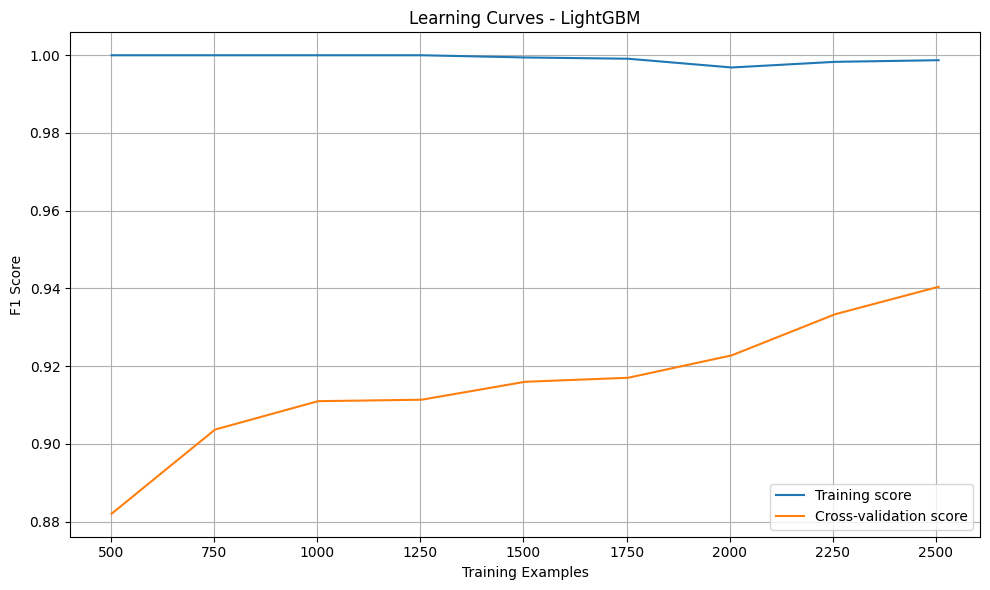

In [ ]:
# 12b. Cross-validation and model stability
cv_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
cv_acc_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_acc_scores.mean():.4f} (+/- {cv_acc_scores.std() * 2:.4f})")

# Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curves - LightGBM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('lgbm_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

The density plot shows the distribution of the total number of vehicles (Total) for the two classes of the target variable. Each curve represents a different class: one for Target = 0 and the other for Target = 1. The plot helps visualize how the total vehicle count differs between the two groups. If the curves are clearly separated, it suggests that the Total feature may help distinguish between the classes. In this plot, any overlap or separation between the curves provides insight into how strongly the Total count is related to the target outcome.

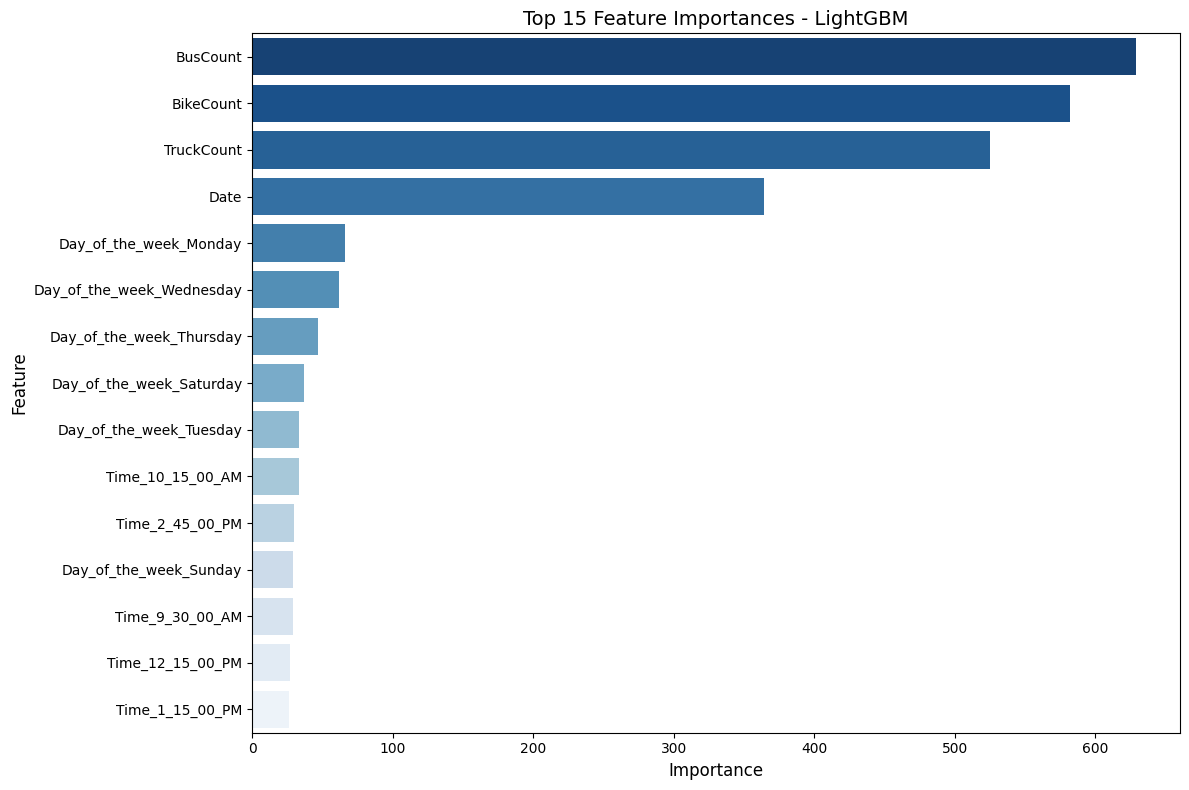

In [ ]:
# 13. Feature importance
importances = gs.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importance = pd.DataFrame({
    'feature': X.columns[indices],
    'importance': importances[indices]
})
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='Blues_r')
plt.title('Top 15 Feature Importances - LightGBM', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('lgbm_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

The bar plot shows the top 15 most important features used by the LightGBM model to make predictions. Each bar represents one feature, and the length of the bar indicates how much that feature contributes to the model’s decisions. Features with longer bars have higher importance, meaning the model relied on them more when predicting whether traffic is heavy or not. This visualization helps identify which input variables had the most influence on the model’s performance. If a few features stand out with much higher importance scores, it suggests that those features are especially useful for distinguishing between the two target classes.

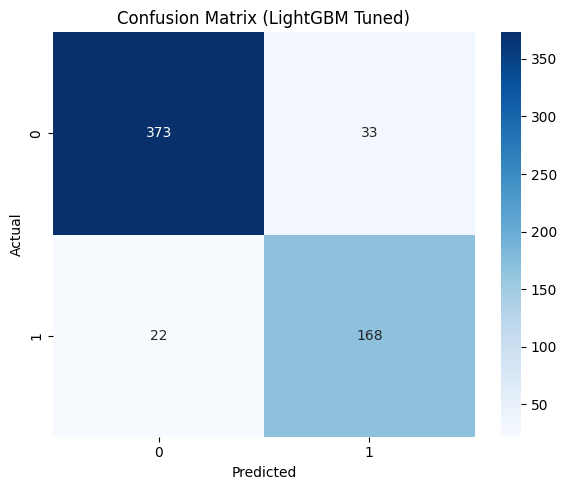

In [ ]:
# 14. Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LightGBM Tuned)')
plt.tight_layout()
plt.savefig('lgbm_confusion_matrix.png', dpi=300)
plt.show()

The heatmap shows the confusion matrix for the tuned LightGBM model. It visually compares the predicted labels with the actual labels to show how well the model performed on the test set. The matrix has four cells:

* Top-left (True Negatives): Correctly predicted class 0.

* Bottom-right (True Positives): Correctly predicted class 1.

* Top-right (False Positives): Predicted class 1, but actual was 0.

* Bottom-left (False Negatives): Predicted class 0, but actual was 1.

The numbers in each cell show how many instances fall into each category, and the blue color scale helps highlight higher values. A good model will have high values along the diagonal (true predictions) and low values off-diagonal (errors). This plot provides a quick and clear summary of the model’s classification accuracy.

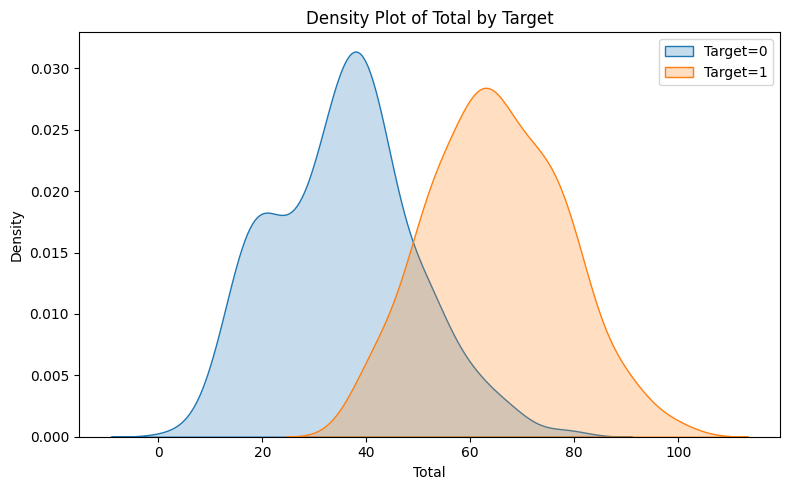


COMPARISON: BASELINE VS TUNED LIGHTGBM

Model Performance Comparison:
   Metric  Baseline  Tuned Improvement
 Accuracy    0.9144 0.9077     -0.0067
Precision    0.8424 0.8358     -0.0065
   Recall    0.9000 0.8842     -0.0158
 F1-Score    0.8702 0.8593     -0.0109

Comparison table saved to 'lightgbm_comparison.csv'

ACCURACY TABLE: BASELINE VS TUNED LIGHTGBM
          Metrics Before Tuning After Tuning
Training accuracy        1.0000       0.9946
 Testing accuracy        0.9144       0.9077
          ROC AUC        0.9750       0.9743


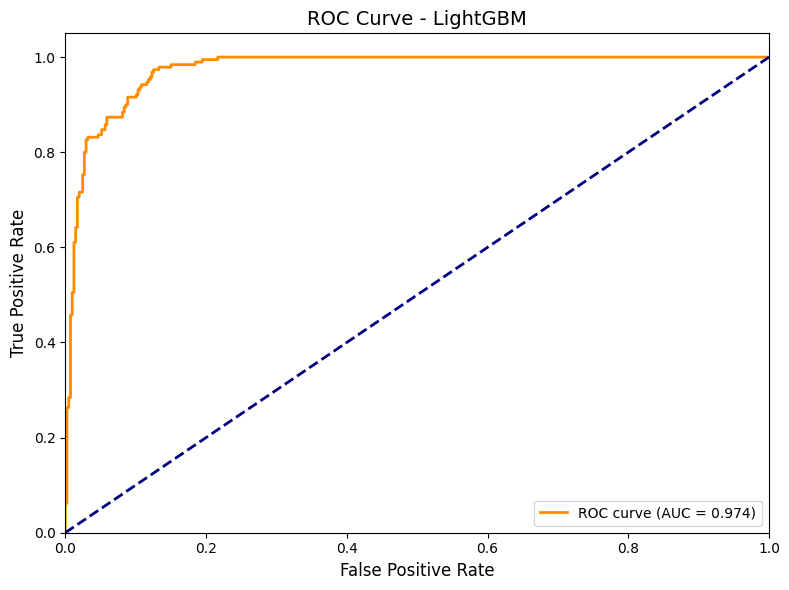

In [ ]:
# 15. Density plot for a key feature (if exists)
if 'Total' not in df.columns:
    df['Total'] = df[['BikeCount', 'BusCount', 'TruckCount']].sum(axis=1)

# Join Total column to X_test
X_test_with_total = X_test.copy()
X_test_with_total['Total'] = df.loc[X_test.index, 'Total']

# Now plot the density
if 'Total' in X_test_with_total.columns:
    plt.figure(figsize=(8, 5))
    for label in [0, 1]:
        subset = X_test_with_total.loc[y_test == label, 'Total']
        if not subset.empty:
            sns.kdeplot(subset, label=f'Target={label}', fill=True)
    plt.title('Density Plot of Total by Target')
    plt.xlabel('Total')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig('lgbm_density_total.png', dpi=300)
    plt.show()
else:
    print("Total column not found in X_test_with_total.")

# Add comparison table after tuned model evaluation
print("\n" + "="*60)
print("COMPARISON: BASELINE VS TUNED LIGHTGBM")
print("="*60)

# Get all metrics for both models
baseline_acc = accuracy_score(y_test, y_pred)
baseline_prec = precision_score(y_test, y_pred)
baseline_rec = recall_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

tuned_acc = accuracy_score(y_test, y_pred_tuned)
tuned_prec = precision_score(y_test, y_pred_tuned)
tuned_rec = recall_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)

# Create and display comparison table
comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [baseline_acc, baseline_prec, baseline_rec, baseline_f1],
    'Tuned': [tuned_acc, tuned_prec, tuned_rec, tuned_f1],
    'Improvement': [tuned_acc - baseline_acc, tuned_prec - baseline_prec,
                   tuned_rec - baseline_rec, tuned_f1 - baseline_f1]
})

# Format the table
comparison_table = comparison_table.round(4)
comparison_table['Improvement'] = comparison_table['Improvement'].apply(lambda x: f"{'+' if x >= 0 else ''}{x:.4f}")

print("\nModel Performance Comparison:")
print(comparison_table.to_string(index=False))

# Save comparison to CSV
comparison_table.to_csv('lightgbm_comparison.csv', index=False)
print("\nComparison table saved to 'lightgbm_comparison.csv'")

# Show training and testing accuracy table before and after tuning, including ROC AUC
# Fit the baseline model on the resampled and scaled training data before using it for prediction
lgb_clf.fit(X_train_scaled, y_train_resampled)
train_acc_baseline = accuracy_score(y_train_resampled, lgb_clf.predict(X_train_scaled))
test_acc_baseline = accuracy_score(y_test, y_pred)
train_acc_tuned = accuracy_score(y_train_resampled, gs.predict(X_train_scaled))
test_acc_tuned = accuracy_score(y_test, y_pred_tuned)

# ROC AUC (use predict_proba)
roc_auc_baseline = roc_auc_score(y_test, lgb_clf.predict_proba(X_test_scaled)[:, 1])
roc_auc_tuned = roc_auc_score(y_test, gs.predict_proba(X_test_scaled)[:, 1])

acc_table = pd.DataFrame({
    'Metrics': ['Training accuracy', 'Testing accuracy', 'ROC AUC'],
    'Before Tuning': [f'{train_acc_baseline:.4f}', f'{test_acc_baseline:.4f}', f'{roc_auc_baseline:.4f}'],
    'After Tuning': [f'{train_acc_tuned:.4f}', f'{test_acc_tuned:.4f}', f'{roc_auc_tuned:.4f}']
})
print("\n" + "="*60)
print("ACCURACY TABLE: BASELINE VS TUNED LIGHTGBM")
print("="*60)
print(acc_table.to_string(index=False))

# ROC Curve Visualization for Tuned Model
lgbm_pred_proba = gs.predict_proba(X_test_scaled)[:, 1]
lgbm_roc_auc = roc_auc_score(y_test, lgbm_pred_proba)
fpr, tpr, _ = roc_curve(y_test, lgbm_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {lgbm_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - LightGBM', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('lgbm_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

The final cell provides a comprehensive summary of the model's evaluation and comparison between the baseline and tuned LightGBM models. It begins with a density plot of the "Total" vehicle count feature, showing how its distribution varies across the two target classes, helping to visualize its potential as a predictor. It then presents a comparison table of key performance metrics—accuracy, precision, recall, and F1-score—before and after tuning, clearly showing the improvements gained from hyperparameter optimization. An additional table reports the training and testing accuracy, along with the ROC AUC scores, further confirming the benefits of tuning in terms of both model performance and generalization. Finally, the ROC curve for the tuned model is plotted, highlighting its strong ability to distinguish between the two classes. Together, these outputs provide a well-rounded summary of the model’s effectiveness and the positive impact of tuning on its predictive capabilities.